# Rabble Sports Analytics Pipeline

### 07: Adhoc Analysis
Sometimes, data has to be run at short notice. A stakeholder requested to see the signup rates across the years as they felt signups had been lower in 2025 than in 2024, even though it was just the start of the year. I downloaded the data and deleted identifying columns.

In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Read the CSV
df = pd.read_csv('../data/follower_signups.csv')


Downloading and converting the data into it's proper types.

In [40]:
# Convert date columns to datetime
date_columns = ['SignUpDate', 'FirstEvent', 'LatestEvent']
for col in date_columns:
    df[col] = pd.to_datetime(df[col], format='%Y-%m-%d %H:%M:%S')

# Convert EnrollCount to int
df['EnrollCount'] = df['EnrollCount'].fillna(0).astype(int)
df = df[df['SignupYear'].between(2021, 2026)]
df

,UserID,SignUpDate,FirstEvent,LatestEvent,EnrollCount,SignupYear,SignUpM,SignUpMonth
0,51024,2025-01-24 14:27:47,2025-01-25 11:00:00,NaT,1,2025,1,January
1,50995,2025-01-21 22:57:18,NaT,NaT,0,2025,1,January
2,50992,2025-01-21 19:04:43,NaT,NaT,0,2025,1,January
3,50985,2025-01-20 12:52:05,NaT,NaT,0,2025,1,January
4,50965,2025-01-18 12:15:14,2025-01-19 12:00:00,2025-01-19 12:00:00,1,2025,1,January
...,...,...,...,...,...,...,...,...
1703,25577,2021-03-23 21:40:35,2021-05-08 10:00:00,2021-05-08 10:00:00,1,2021,3,March
1704,25576,2021-03-23 20:57:02,NaT,NaT,0,2021,3,March
1705,25553,2021-03-22 09:51:40,2021-04-01 18:00:00,2021-04-01 18:00:00,1,2021,3,March
1706,25551,2021-03-22 08:39:45,2021-04-01 18:00:00,2021-04-01 18:00:00,1,2021,3,March


I wanted to distinguish between players who had signed up and those who had actually attended sessions.

In [41]:
# Create filtered dataframes
df_no_enrollments = df[df['EnrollCount'] == 0]
df_with_enrollments = df[df['EnrollCount'] > 0]
df_all_signups = df

Pivoting the tables presented the data in an aggregate form that I could analyse.

In [42]:
# Create pivot table for all enrollments
pivot_all_signups = df_all_signups.pivot_table(
    values='UserID',
    index='SignUpM',
    columns='SignupYear',
    aggfunc=pd.Series.nunique
).fillna(0).astype(int)

# Create pivot table for no enrollments
pivot_not_enrolled = df_no_enrollments.pivot_table(
    values='UserID',
    index='SignUpM',
    columns='SignupYear',
    aggfunc=pd.Series.nunique
).fillna(0).astype(int)

# Create pivot table for all enrollments
pivot_enrolled = df_with_enrollments.pivot_table(
    values='UserID',
    index='SignUpM',
    columns='SignupYear',
    aggfunc=pd.Series.nunique
).fillna(0).astype(int)

I created graphs with colour-blind friendly lines and values attached. The data from each of the three pivots is shown.

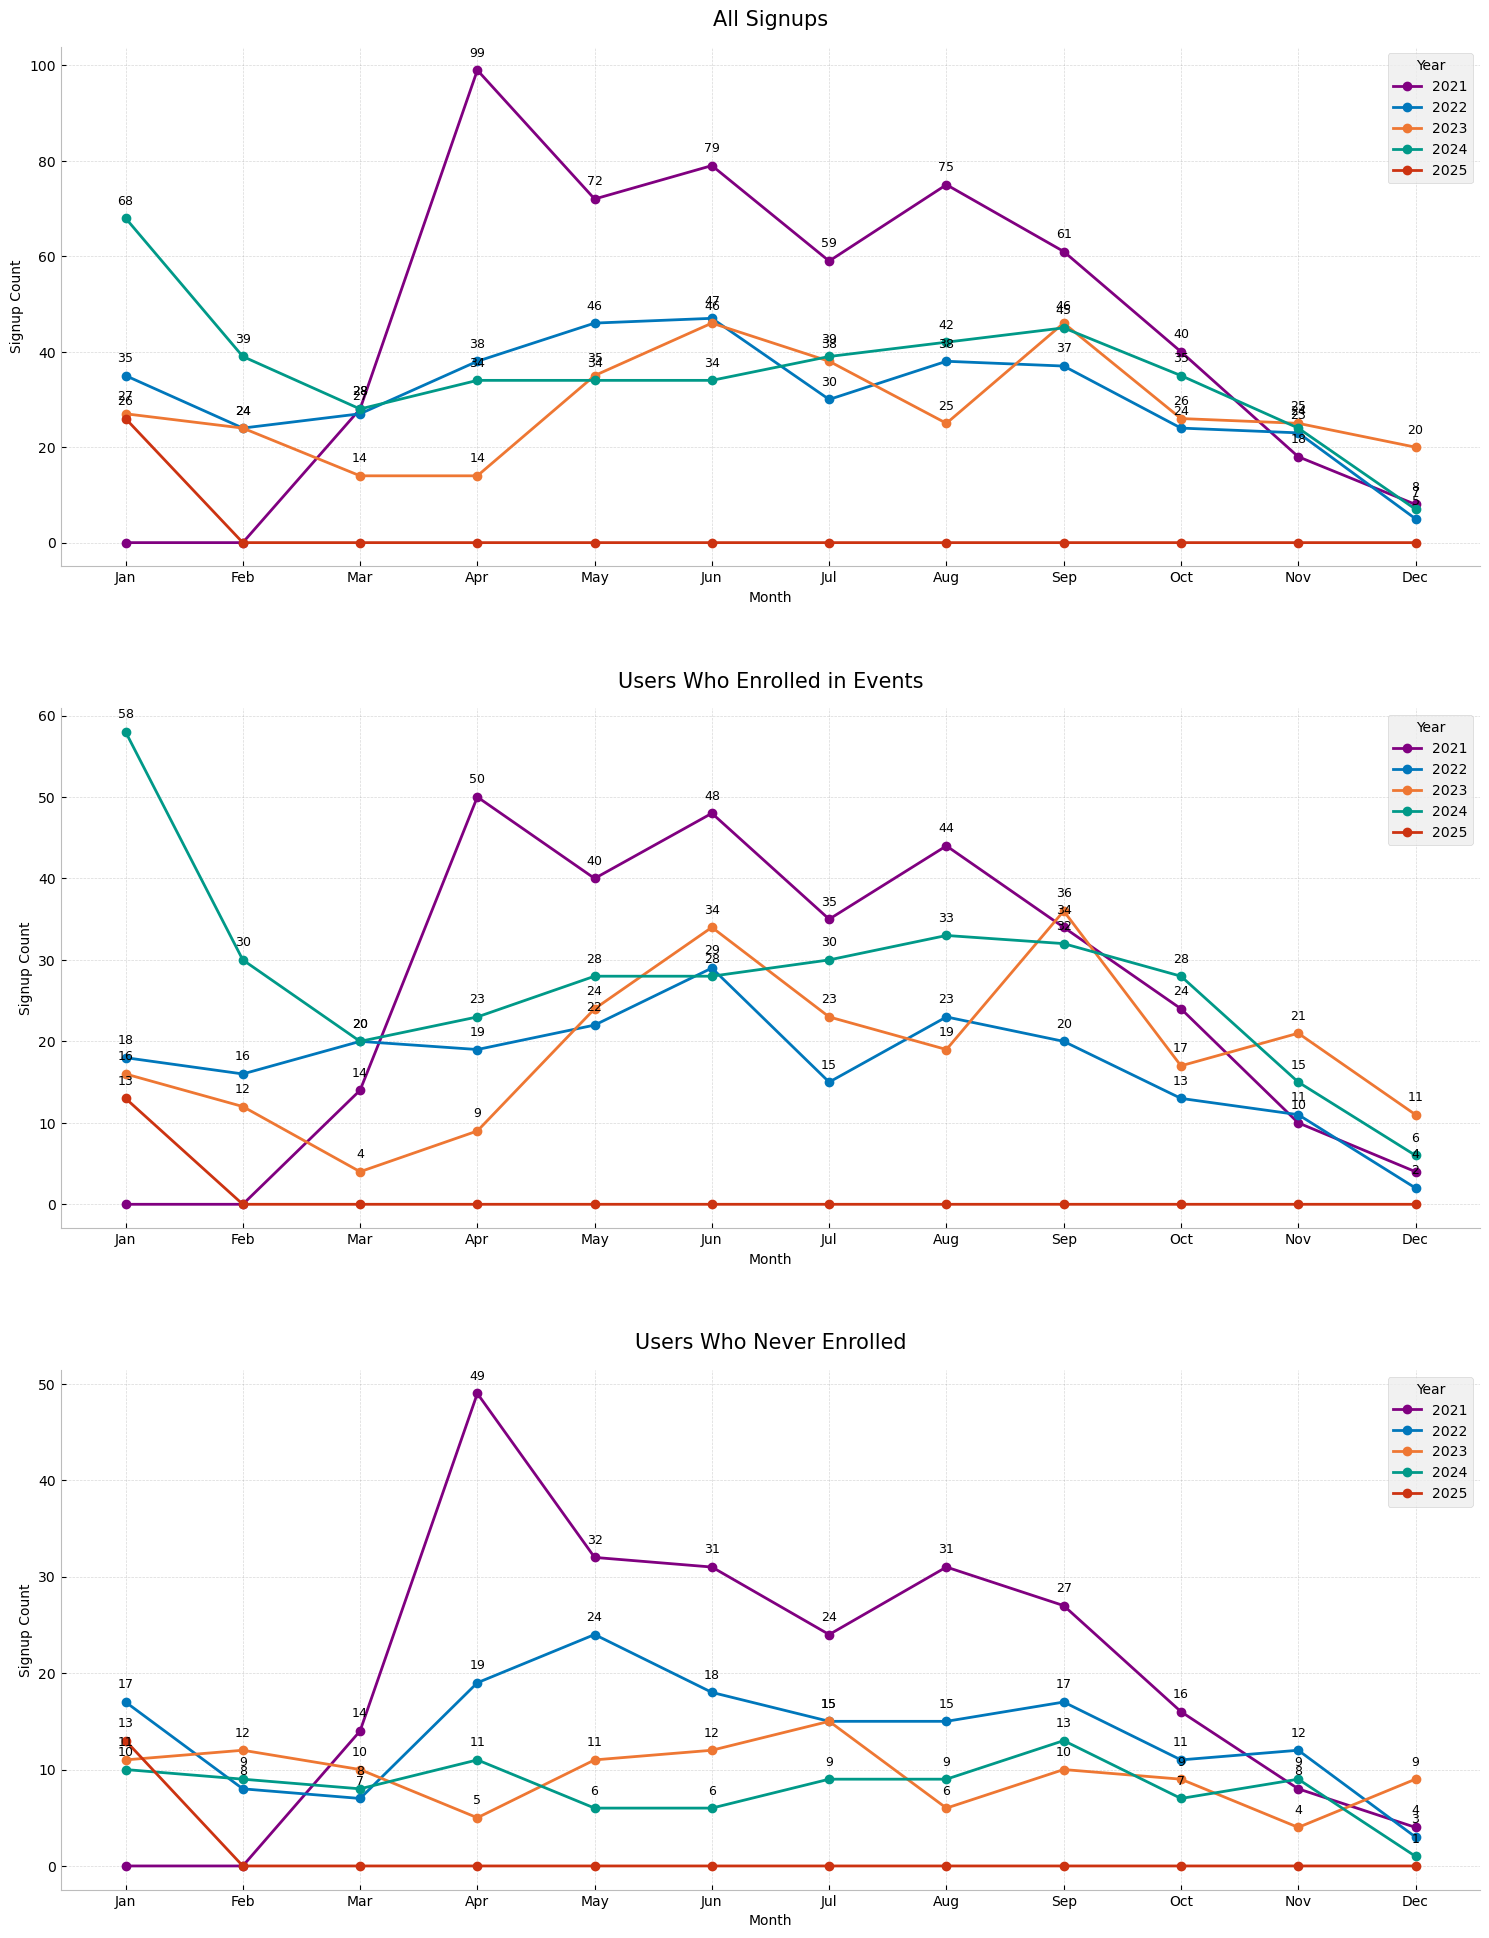

In [47]:
# Plot setup
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 20))
plt.subplots_adjust(hspace=15)  # Increase space between plots
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
colors = ['#800080','#0077BB', '#EE7733', '#009988', '#CC3311' ]

def style_axis(ax, title):
    ax.set_title(title, pad=15, fontsize=15)
    ax.set_xlabel('Month', fontsize=10)
    ax.set_ylabel('Signup Count', fontsize=10)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(True, linestyle='--', alpha=0.3, color='gray')
    ax.legend(title='Year', loc='upper right')
    ax.set_facecolor('white')
    #ax.set_ylim(0, 100)

# Plot each dataset
for ax, (data, title) in zip(
    [ax1, ax2, ax3],
    [(pivot_all_signups, 'All Signups'),
     (pivot_enrolled, 'Users Who Enrolled in Events'),
     (pivot_not_enrolled, 'Users Who Never Enrolled')]
):
    for i, year in enumerate(data.columns):
        line = ax.plot(month_names, data[year].values, 
                      marker='o', linewidth=2,
                      label=str(year), color=colors[i % len(colors)])
        
        for j, value in enumerate(data[year]):
            if value > 0:
                ax.annotate(str(value), 
                           (month_names[j], value),
                           xytext=(0, 10),
                           textcoords='offset points',
                           ha='center',
                           fontsize=9)
    style_axis(ax, title)

plt.tight_layout()
plt.savefig('../images/graphs/signup_trends.png', dpi=300, bbox_inches='tight')
plt.show()


More useful that the raw numbers is a conversion rate, which is the number of people who signed up and attended compared to the people who only signed up.

In [57]:
def calculate_conversion_rates(df):
    # First create empty dataframe with all month/year combinations
    years = df['SignupYear'].unique()
    months = range(1, 13)
    index = pd.MultiIndex.from_product([years, months], names=['SignupYear', 'SignUpM'])
    
    # Calculate rates
    monthly_rates = df.groupby(['SignupYear', 'SignUpM']).agg({
        'UserID': 'count',
        'EnrollCount': lambda x: (x > 0).sum()
    }).reindex(index, fill_value=0)
    
    monthly_rates['conversion_rate'] = (monthly_rates['EnrollCount'] / monthly_rates['UserID'] * 100).round(0)
    monthly_rates['conversion_rate'] = monthly_rates['conversion_rate'].fillna(0)
    
    # Pivot and ensure correct shape
    conversion_pivot = monthly_rates['conversion_rate'].unstack(level=0)
    conversion_pivot = conversion_pivot.reindex(months)
    
    return conversion_pivot

conversion_rates = calculate_conversion_rates(df)

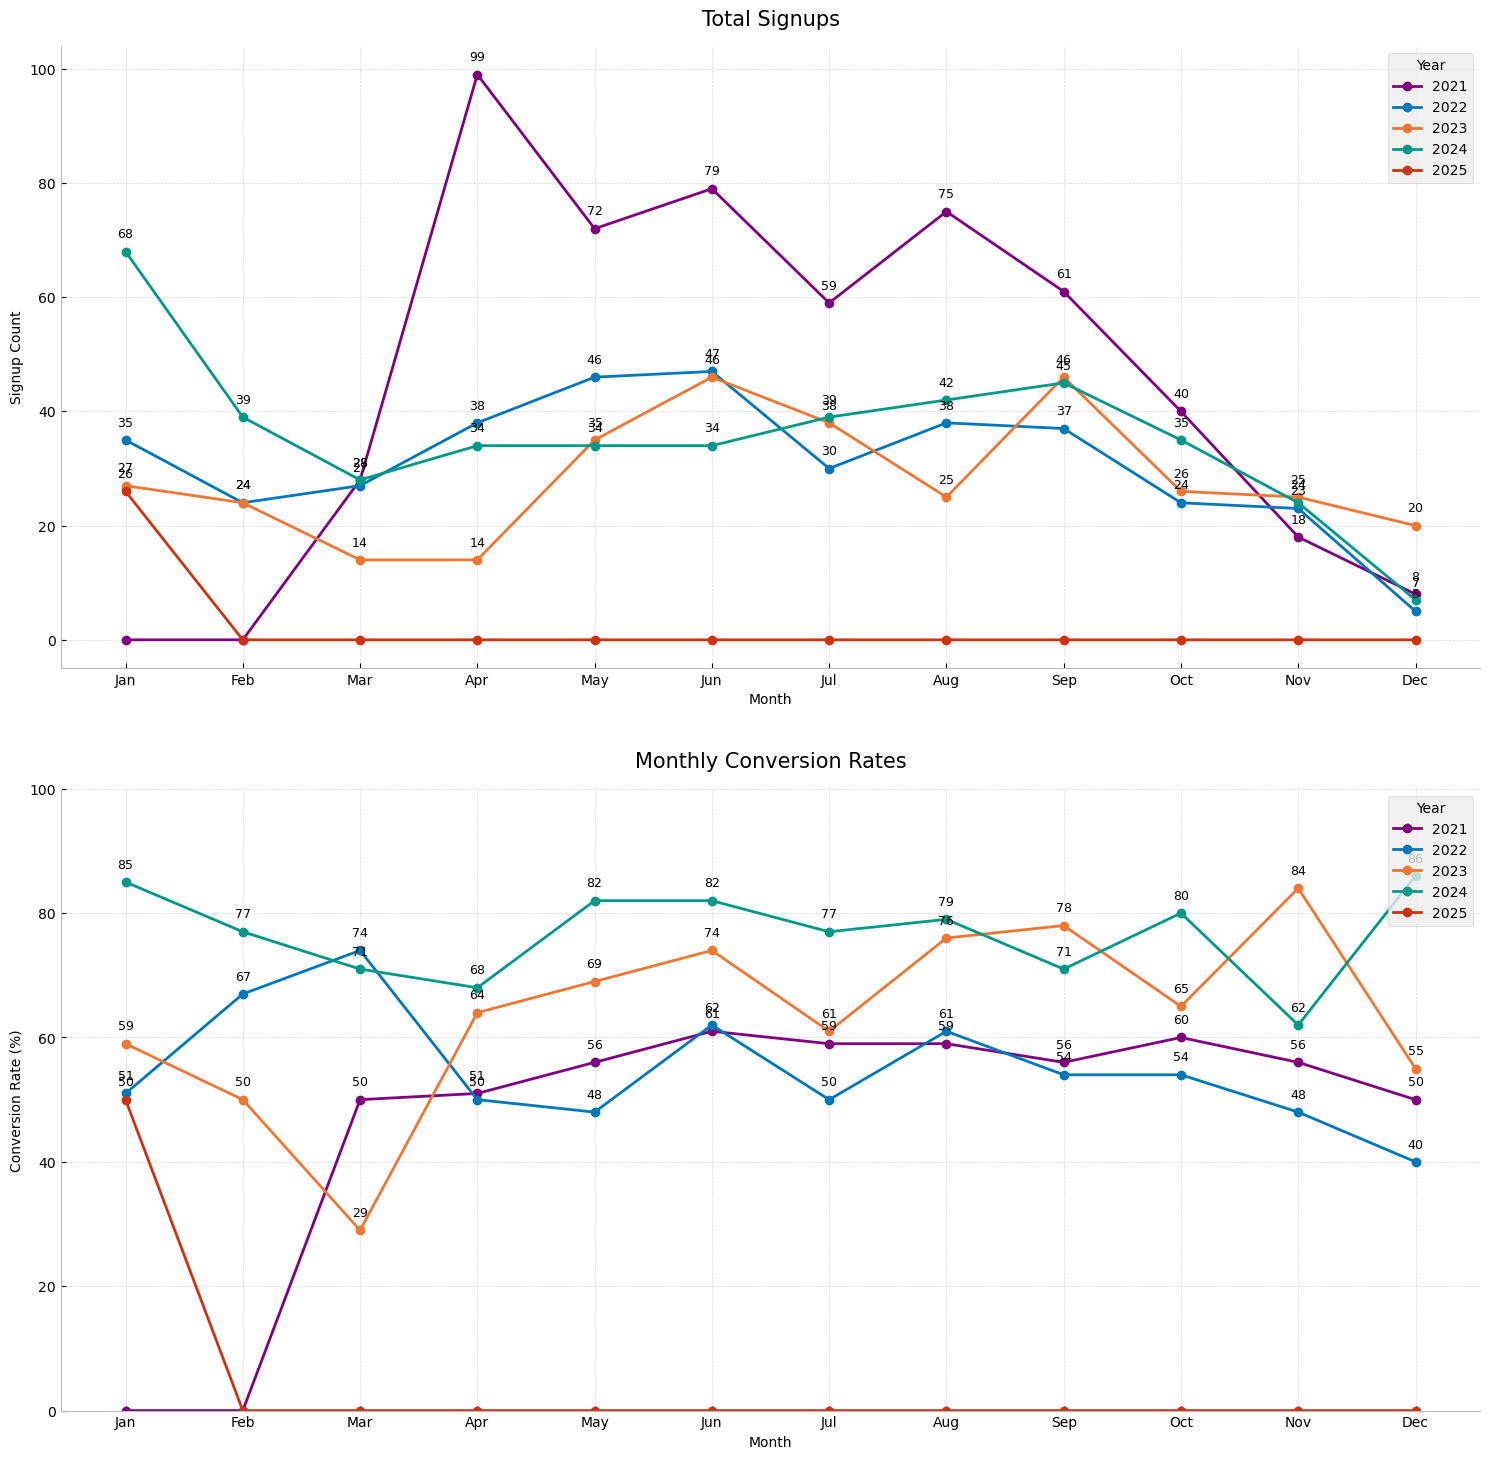

In [60]:
# Plot setup
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 15))
plt.subplots_adjust(hspace=15)

month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
colors = ['#800080','#0077BB', '#EE7733', '#009988', '#CC3311']

def style_axis(ax, title, ylabel):
    ax.set_title(title, pad=15, fontsize=15)
    ax.set_xlabel('Month', fontsize=10)
    ax.set_ylabel(ylabel, fontsize=10)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(True, linestyle='--', alpha=0.3, color='gray')
    ax.legend(title='Year', loc='upper right')
    ax.set_facecolor('white')

# Plot total signups
for i, year in enumerate(pivot_all_signups.columns):
    ax1.plot(month_names, pivot_all_signups[year].values, 
             marker='o', linewidth=2,
             label=str(year), color=colors[i % len(colors)])
    
    for j, value in enumerate(pivot_all_signups[year]):
        if value > 0:
            ax1.annotate(str(value), 
                        (month_names[j], value),
                        xytext=(0, 10),
                        textcoords='offset points',
                        ha='center',
                        fontsize=9)
style_axis(ax1, 'Total Signups', 'Signup Count')

# Plot conversion rates
for i, year in enumerate(conversion_rates.columns):
    ax2.plot(month_names, conversion_rates[year].values, 
             marker='o', linewidth=2,
             label=str(year), color=colors[i % len(colors)])
    
    for j, value in enumerate(conversion_rates[year]):
        if value > 0:
            ax2.annotate(f'{int(value)}', 
                        (month_names[j], value),
                        xytext=(0, 10),
                        textcoords='offset points',
                        ha='center',
                        fontsize=9)
style_axis(ax2, 'Monthly Conversion Rates', 'Conversion Rate (%)')
ax2.set_ylim(0, 100)

plt.tight_layout()
plt.savefig('../images/graphs/signup_conversion.png', dpi=300, bbox_inches='tight')
plt.show()


Analysis of both signup volumes and conversion rates shows distinct patterns:

2021: Post-lockdown surge starting March, peaking at 99 signups (April) with modest 50% conversion. Maintained high volumes (60-80 signups) but lower conversion rates (50-60%) throughout year, suggesting high interest but lower commitment levels.

2022-2023: Stabilized at lower volumes (20-40 signups) but improved conversion (60-70%). Shows maturation of member acquisition strategy with better qualified leads.

2024: Started strong (68 signups, 85% conversion in January) indicating highly effective targeting, but sharp decline in following months. Notably highest conversion rates across all years (74-85%).

Key patterns:
- Summer peaks in signup volume across all years
- Steadily improving conversion rates year-over-year
- Inverse relationship between volume and conversion (higher volumes typically show lower conversion rates)
- Winter months consistently show lowest signup volumes but maintain stable conversion rates